## A/B тест: влияние фичи на revenue (continuous)

<strong>Цель:</strong> сравнить средний revenue между control и test

<strong>H0:</strong> mean_test = mean_control

<strong>H1:</strong> mean_test ≠ mean_control

<strong>Alpha:</strong> 0.05

<strong>Метрика:</strong> revenue на пользователя

In [38]:
# импорт библиотек
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

In [39]:
# загрузка данных
DATA_PATH = Path('../data/ab_continuous_revenue.csv')
df = pd.read_csv(DATA_PATH)
df.head(10)

,user_id,group,revenue,country
0,11869,test,0.00,ES
1,5709,control,0.00,ES
2,11006,test,20.34,DE
3,10482,test,12.70,DE
4,7386,test,0.00,DE
5,11841,test,0.00,DE
6,38,control,0.00,PL
7,7053,test,2.06,DE
8,3180,control,0.00,FR
9,6902,test,0.00,DE


## Обзор данных

На этом шаге проверяю:
- структуру датасета и типы колонок
- наличие пропусков
- баланс групп (примерно одинаковые размеры)
- базовые характеристики метрики 'revenue' (среднее/квантили), чтобы понимать масштаб и “хвост”


In [40]:
# проверка структуры и пропусков
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12205 entries, 0 to 12204
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  12205 non-null  int64  
 1   group    12205 non-null  object 
 2   revenue  12205 non-null  float64
 3   country  12199 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 381.5+ KB


user_id    0
group      0
revenue    0
country    6
dtype: int64

In [41]:
# как распределены пользователи по группам (баланс групп)
df['group'].value_counts(), df['group'].value_counts(normalize=True)

(group
 test       6202
 control    6003
 Name: count, dtype: int64,
 group
 test       0.508152
 control    0.491848
 Name: proportion, dtype: float64)

In [42]:
# базовая сводка по revenue
df['revenue'].describe(), df['revenue'].quantile([0.5, 0.9, 0.99])

(count    12205.000000
 mean         3.546057
 std         10.711839
 min          0.000000
 25%          0.000000
 50%          0.000000
 75%          1.930000
 max        392.860000
 Name: revenue, dtype: float64,
 0.50     0.0000
 0.90    10.8000
 0.99    47.1292
 Name: revenue, dtype: float64)

## Валидация на уровне пользователей (user-level)

Важно, чтобы:
- один пользователь не учитывался несколько раз (иначе он “весит” больше других)
- один пользователь не попадал в разные группы (иначе сравнение групп ломается)

Если нахожу дубли, привожу данные к формату: 1 user_id = 1 наблюдение

In [43]:
# проверка дублей по user_id
n_users = df['user_id'].nunique()
n_rows = len(df)
n_users, n_rows

(12200, 12205)

In [44]:
# n_rows > n_users; проверяем какие дубли есть
dups = df[df['user_id'].duplicated(keep=False)].sort_values('user_id')
dups.head(100)

,user_id,group,revenue,country
9584,4902,control,0.00,PL
9611,4902,control,0.00,PL
1185,4907,control,6.15,PL
3338,4907,control,6.15,PL
3160,5199,control,3.16,DE
9288,5199,control,3.16,DE
4003,10498,test,0.00,DE
5585,10498,test,0.00,DE
7856,10708,test,0.00,DE
9496,10708,test,0.00,DE


In [45]:
# так же проверяем чтобы один user не находился в двух группах
users_in_many_groups = (
    df.groupby('user_id')['group'].nunique()
    .sort_values(ascending=False)
)
(users_in_many_groups > 1).sum()

np.int64(0)

In [46]:
# удаляем дубли
df_clean = df.drop_duplicates(subset=['user_id'], keep='first').copy()
df_clean['user_id'].nunique(), len(df_clean)

(12200, 12200)

## Основной тест

Считаю:
- <strong>mean_control</strong> — средний revenue в control
- <strong>mean_test</strong> — средний revenue в test
- <strong>delta</strong> = mean_test - mean_control — разница средних (эффект)

Далее применяю t-test и строю 95% ДИ для разницы средних

In [51]:
# формирую выборки данных
control = df_clean[df_clean['group'] == 'control']['revenue']
test = df_clean[df_clean['group'] == 'test']['revenue']

In [54]:
# получаю метрики и эффект
mean_control = control.mean()
mean_test = test.mean()
delta = mean_test - mean_control

mean_control, mean_test, delta

(np.float64(3.4865099999999996),
 np.float64(3.605041935483871),
 np.float64(0.11853193548387164))

In [53]:
# t-test + 95% CI
cm = CompareMeans(DescrStatsW(test), DescrStatsW(control))

t_stat, p_val, _ = cm.ttest_ind(usevar='unequal')
ci_low, ci_high = cm.tconfint_diff(alpha=0.05, usevar='unequal')

t_stat, p_val, ci_low, ci_high

(np.float64(0.6100091761572833),
 np.float64(0.5418672604409718),
 np.float64(-0.2623504003074782),
 np.float64(0.4994142712752206))

## Промежуточный вывод (после основного теста):
- Эффект: delta = 0.1185
- p-value: p_val = 0.54 → незначимо при alpha=0.05
- 95% ДИ: -0.26:0.499 → пересекает 0

## Диагностика на распределение и выбросы

Дополнительно смотрю:
- гистограмму распределения по группам (с log-шкалой по оси count)
- boxplot для сравнения основной массы и выбросов
- max и p99 (99-й перцентиль), чтобы оценить хвост количественно

Цель — понять, насколько среднее и итоговый эффект чувствительны к редким большим значениям

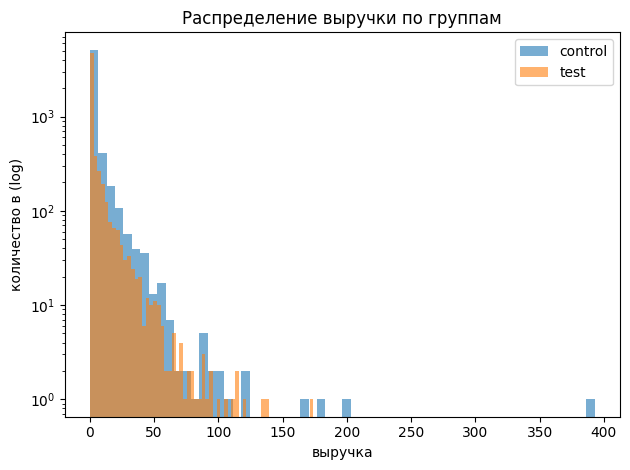

In [50]:
# гистограмма распределения по группам
plt.figure()
plt.hist(control, bins=60, alpha=0.6, label='control')
plt.hist(test, bins=60, alpha=0.6, label='test')
plt.yscale('log')
plt.xlabel('выручка')
plt.ylabel('количество в (log)')
plt.title('Распределение выручки по группам')
plt.legend()
plt.tight_layout()
Path('../figures').mkdir(parents=True, exist_ok=True)
plt.savefig('../figures/revenue_hist.png', dpi=150, bbox_inches='tight')
plt.show()

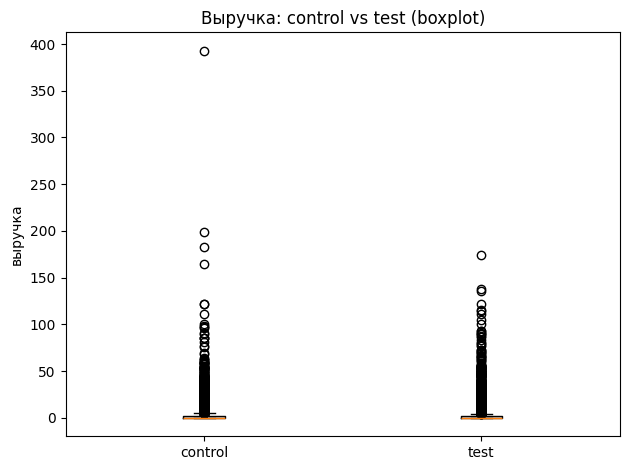

In [29]:
# boxplot для сравнения основной массы и выбросов по группам
plt.figure()
plt.boxplot([control, test], tick_labels=['control', 'test'])
plt.ylabel('выручка')
plt.title('Выручка: control vs test (boxplot)')
plt.tight_layout()
Path('../figures').mkdir(parents=True, exist_ok=True)
plt.savefig('../figures/revenue_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
# max и p99 (99-й перцентиль) по группам
control_max, test_max = control.max(), test.max()
control_p99, test_p99 = control.quantile(0.99), test.quantile(0.99)

control_max, test_max, control_p99, test_p99

(np.float64(392.86),
 np.float64(173.98),
 np.float64(45.24080000000002),
 np.float64(49.53020000000001))

## Проверка чувствительности: “основная масса” без верхнего хвоста

Провожу проверку устойчивости: ограничиваю revenue сверху общим порогом cap (на уровне p99), чтобы временно исключить верхний 1% значений.

Это <strong>не замена основного результата</strong>, а дополнительная диагностика:
- если эффект сильно меняется после cap, значит исходная разница могла быть чувствительна к хвосту/редким выбросам
- если эффект почти не меняется, значит вывод устойчив.

В этом блоке сравниваю эффект на:
- всех данных
- данных revenue <= cap

In [22]:
# нахожу единый cap и основную массу для каждой группы
cap = min(control_p99, test_p99)
control_main = control[control <= cap]
test_main = test[test <= cap]

len(control), len(control_main), len(test), len(test_main), cap

(6000, 5940, 6200, 6123, np.float64(45.24080000000002))

In [55]:
# нахожу delta (дельту) на основной массе
delta_main = test_main.mean() - control_main.mean()
test_main.mean(), control_main.mean(), delta_main

(np.float64(2.79307365670423),
 np.float64(2.7495521885521885),
 np.float64(0.043521468152041276))

In [56]:
# 95% CI на основной массе
cm_main = CompareMeans(DescrStatsW(test_main), DescrStatsW(control_main))
ci_low_main, ci_high_main = cm_main.tconfint_diff(alpha=0.05, usevar='unequal')
ci_low_main, ci_high_main

(np.float64(-0.19545233655630836), np.float64(0.2824952728603909))

## Финальный вывод

- По всем данным статистически значимого эффекта на revenue не выявлено: p-value > 0.05, 95% ДИ пересекает 0
- Распределение revenue имеет длинный хвост и редкие большие значения; в control наблюдается экстремальный выброс
- Проверка устойчивости (cap по p99) показала, что эффект на “основной массе” пользователей становится ближе к нулю → среднее чувствительно к хвосту

<strong>Решение:</strong> на основании этого эксперимента фичу внедрять нельзя; для следующей итерации нужно больше данных
